# TrpCage: mindist and rmsdCA model

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
sys.path.append("/Users/suarezalvareze2/Documents/workspace/NMpathAnalysis/nmpath")
import numpy as np
import pyemma
import mdtraj as md
from glob import glob
import math


from auxfunctions import *
from mfpt import *
from clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel

# Print
from IPython.display import Markdown, display

## Define auxiliary functions

Here, we define a set of functions which will make plotting easier.

In [2]:
def plot_its(lags, model, bayesian_model, ax, ylabel, dt=2.0E-4, confidence_interval=0.98):
    cout = 50 * (1.0 - confidence_interval)
    ax.fill_between(
        lags * dt,
        0.0,
        lags * dt,
        alpha=0.5, facecolor='grey')
    ax.plot(lags * dt, lags * dt, linewidth=2, color='black')
    for i in range(model.shape[1]):
        ax.fill_between(
            lags * dt,
            np.percentile(bayesian_model[:, :, i], cout, axis=1),
            np.percentile(bayesian_model[:, :, i], 100 - cout, axis=1),
            alpha=0.3, facecolor='C%d' % i)
        ax.plot(lags * dt, model[:, i], color='C%d' % i)
        ax.plot(lags * dt, np.median(bayesian_model[:, :, i], axis=1), ':o', color='C%d' % i)
    ax.set_xlabel(r'lagtime / $\mu$s')
    ax.set_ylabel(ylabel)
    
def get_lagtime_from_array(lags, lagtime, dt=2.0E-4):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def get_free_energy(tics, bins=100, use=[0, 1]):
    z, xedge, yedge = np.histogram2d(*tics[:, use].T, bins=bins)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])
    z = np.maximum(z, np.min(z[z > 0]))
    f = -np.log(z)
    f -= np.min(f)
    xx, yy = np.meshgrid(x, y)
    xy = np.array([xx.reshape(-1,), yy.reshape(-1,)]).T
    return dict(x=x, y=y, xx=xx, yy=yy, xy=xy, f=f.T, use=use)

def draw_free_energy(fe, ax, bw=False):
    if bw:
        cmap = mpl.cm.bone
        alpha=0.2
    else:
        cmap = mpl.cm.jet
        alpha=None
    levels = np.linspace(fe['f'].min(), fe['f'].max(), 100, endpoint=False)
    return ax.contourf(fe['x'], fe['y'], fe['f'], levels, cmap=cmap, alpha=alpha, vmin=0.0, vmax=np.max(fe['f']))

def get_metastable_distribution(model, state):
    pi = model.stationary_distribution.copy()
    for i, s in enumerate(model.metastable_sets):
        if i == state:
            continue
        pi[s] = 0.0
    pi /= pi.sum()
    return pi

def printmd(string):
    display(Markdown(string))

def plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list):
    t_cut_values_ns = np.array(t_cut_values)*dt
    t_min_list_ns = np.array(t_min_list)*dt
    t_max_list_ns = np.array(t_max_list)*dt
    t_AB_list_ns = np.array(t_AB_list)*dt

    fig = plt.figure(figsize=(15,3))

    ax1 =  fig.add_subplot(131)
    ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
    ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)
    #ax1.set_xlim(40,105)

    ax2 =  fig.add_subplot(132)
    ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
    ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)
    #ax2.set_xlim(40,105)

    ax3 =  fig.add_subplot(133)
    ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
    ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)
    #ax3.set_xlim(40,105)

    plt.show()

def plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs, step=100):
    max_ = len(t_cut_values)
    select_to_plot= range(0, max_ ,3) # This will print the first column of the free energy plots


    for i in select_to_plot:
        macrostates = big_clusters_list[i]
        rmsd_cluster0=[]
        rmsd_cluster1=[]

        for j, microstate in enumerate(dtrajs[0]):  # There is only one traj
            if j%step == 0:
                if microstate in macrostates[0]:
                    rmsd_cluster0.append(rmsd[j])
                elif (len(macrostates) > 1) and microstate in macrostates[1]:
                    rmsd_cluster1.append(rmsd[j])

        fig = plt.figure(figsize=(5,2))

        plt.hist(rmsd_cluster0, normed=True, bins=25, alpha=0.5,label="cluster-0", edgecolor="r")
        
        if len(macrostates) > 1:
            plt.hist(rmsd_cluster1,normed=True, bins=25, color="b", 
                     alpha=0.5,label="cluster-1", edgecolor="b")

        plt.xlabel("RMSD$(\AA)$",fontsize=12)
        plt.ylabel("Probability Dens.",fontsize=12)
        plt.legend()
        #plt.title("t_cut: {:.2f}ns".format(t_cut_values_ns[i]))
        plt.annotate("t_cut: {:.2f}ns".format(t_cut_values[i]*dt), xy=(1,2))
        plt.xlim([0,7])
        plt.show()


color_sequence = ['#d62728', '#ff9896', '#9467bd',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5', '#98df8a']

## Data source

In [3]:
path = '/Users/suarezalvareze2/Documents/DESHAWTRAJS/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/'
trajs = '2JOF-0-protein-*.dcd'

traj_files = [f for f in sorted(glob(path + trajs))]
pdb_file = path + 'protein.pdb'

## Create a feature reader


In [4]:
features = pyemma.coordinates.featurizer(pdb_file)
features.add_residue_mindist()
features.add_minrmsd_to_ref(path + '2JOF-0-protein-000.dcd', ref_frame=4250)
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)

31-10-17 10:25:45 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


## RMSD

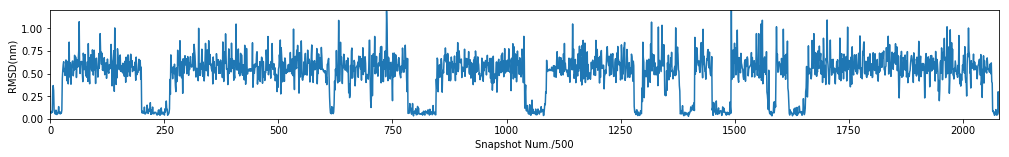

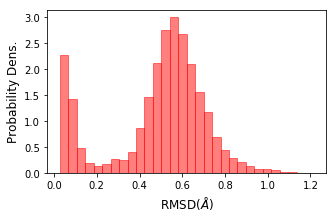

In [5]:
reference = md.load_dcd(path + '2JOF-0-protein-000.dcd', top=pdb_file)

CA_atoms = reference.topology.select('name CA and resid 1 to 18')

rmsd = []

for traj_name in traj_files:
    traj = md.load_dcd(traj_name, top=pdb_file)
    for element in md.rmsd(traj, reference, 4250, atom_indices=CA_atoms):
        rmsd.append(element)

fig = plt.figure(figsize=(17, 2))
plt.plot(rmsd[::500])
plt.axis([0, 2080, 0.0, 1.2])
plt.ylabel('RMSD(nm)')
plt.xlabel('Snapshot Num./500')
plt.show()


#histogram
fig = plt.figure(figsize=(5, 3))

ax1 = fig.add_subplot(111)
ax1.hist(rmsd[::100], normed=True, bins=30, color='r', alpha=0.5, edgecolor='r')
ax1.set_xlabel('RMSD$(\AA)$', fontsize=12)
ax1.set_ylabel('Probability Dens.', fontsize=12)

# to Angstrom
rmsd = np.array(rmsd) * 10.0

## Discretization

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

31-10-17 10:30:12 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


A Jupyter Widget

A Jupyter Widget

/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


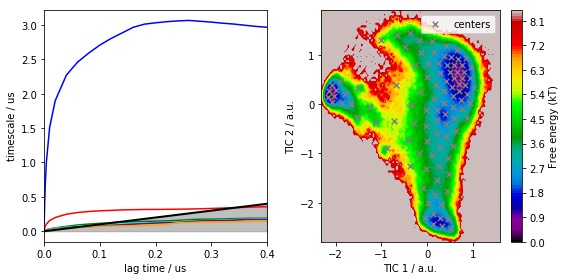

In [6]:
tica = pyemma.coordinates.tica(data=source, lag=5, dim=2).get_output()[0]
cluster = pyemma.coordinates.cluster_kmeans(tica, k=100, max_iter=50)

lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(cluster.dtrajs, lags=lags, errors=None, nits=6),
    ylog=False, ax=axes[0], units='us', dt=2.0E-4)
pyemma.plots.plot_free_energy(*tica.T, ax=axes[1])
axes[1].scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
axes[1].legend()
axes[1].set_xlabel('TIC 1 / a.u.')
axes[1].set_ylabel('TIC 2 / a.u.')
fig.tight_layout()

## MSM estimation and analysis

The ITS convergence suggests to use a lagtime of $\tau\approx0.2\mu s$ and two or maybe even three metastable states. Let's do a quick analysis whether we can actually build a reasonable MSM for the given discretization. We start with the suggested lagtime and do CK tests for the suspected amouts of metastable states.

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Estimated at lagtime 1000 steps


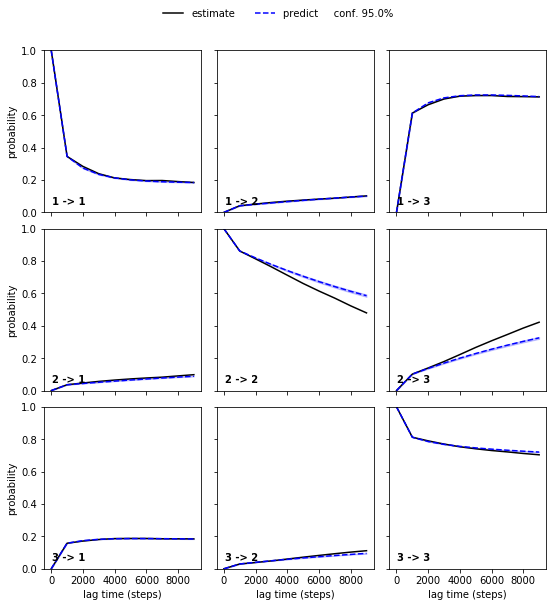

In [7]:
lag = get_lagtime_from_array(lags, 0.2, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(3))
print('Estimated at lagtime %d steps' % lag)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Estimated at lagtime 1000 steps


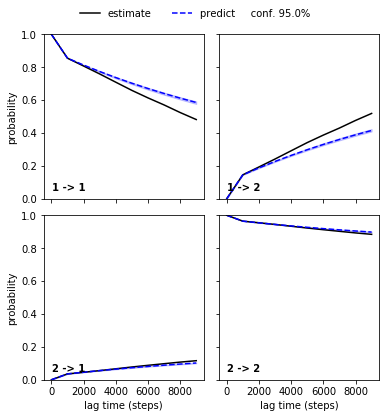

In [8]:
lag = get_lagtime_from_array(lags, 0.2, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

That does not look good! Even though the implied timescales look converged, I would not plce much trust in this.

Let's check for higher lagtimes!

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Estimated at lagtime 1200 steps


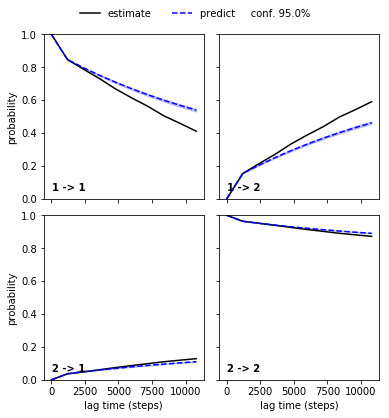

In [9]:
lag = get_lagtime_from_array(lags, 0.25, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Estimated at lagtime 1500 steps


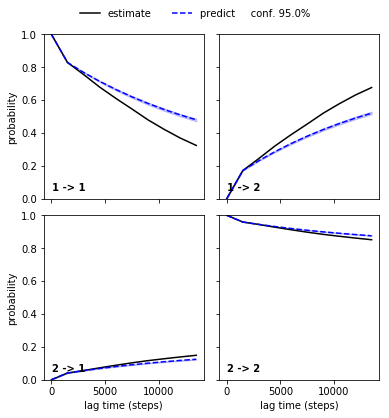

In [10]:
lag = get_lagtime_from_array(lags, 0.3, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

Looks like it gets even worse. How about smaller lagtimes?

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Estimated at lagtime 700 steps


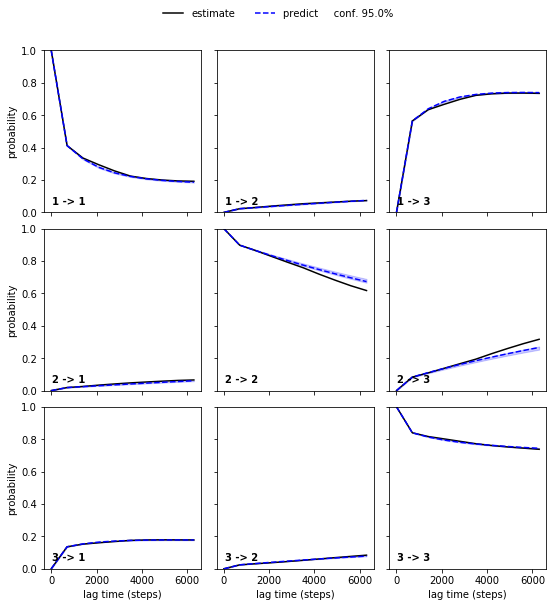

In [11]:
lag = get_lagtime_from_array(lags, 0.15, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(3))
print('Estimated at lagtime %d steps' % lag)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Estimated at lagtime 700 steps


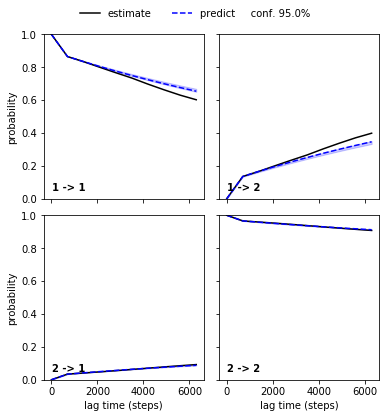

In [12]:
lag = get_lagtime_from_array(lags, 0.15, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Estimated at lagtime 500 steps


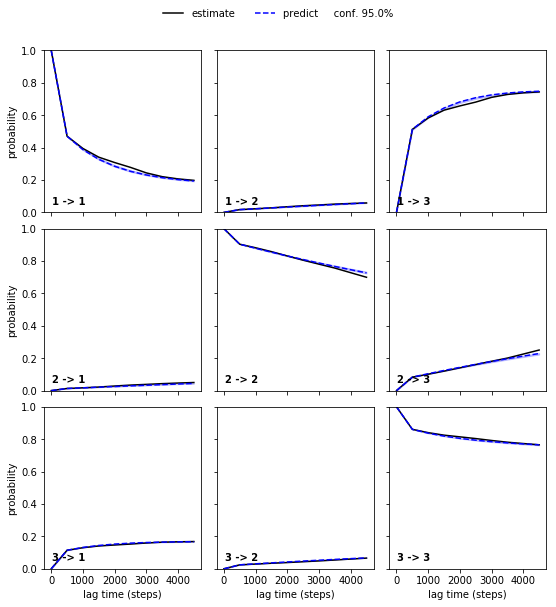

In [13]:
lag = get_lagtime_from_array(lags, 0.1, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(3))
print('Estimated at lagtime %d steps' % lag)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Estimated at lagtime 500 steps


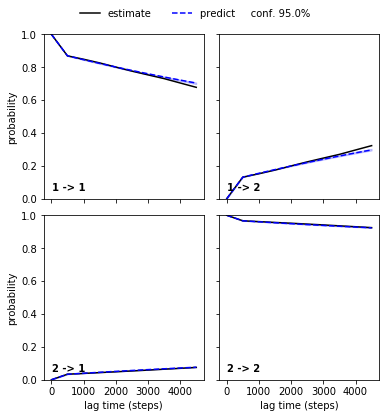

In [14]:
lag = get_lagtime_from_array(lags, 0.1, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

We have either Markovian data or converged implied timescales, but not both. Conclusion: we need a better data set to work on!

## Discretization - RMSD only

The RMSD data for itself already looks kindof metastable. Let's build an MSM on top of that.

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

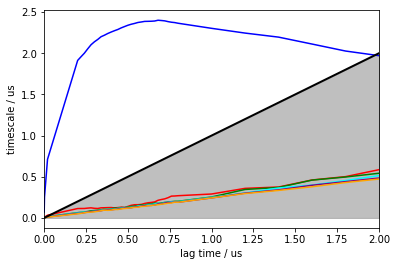

In [15]:
features = pyemma.coordinates.featurizer(pdb_file)
features.add_minrmsd_to_ref(path + '2JOF-0-protein-000.dcd', ref_frame=4250)
rmsd = pyemma.coordinates.load([traj_files], features=features, chunk_size=10000)
centers = np.linspace(rmsd.min(), rmsd.max(), 101)
centers = 0.5 * (centers[1:] + centers[:-1]).reshape(-1, 1)
dtraj = pyemma.coordinates.assign_to_centers(rmsd, centers=centers)

lags = np.asarray([1, 10, 100] + [1000 + i * 100 for i in range(30)] + [1000 * i for i in range(4, 11)])
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(dtraj, lags=lags, errors=None, nits=6),
    ylog=False, units='us', dt=2.0E-4)

This type of data yields a lower ITS maximum than the previous situation and requires a very high lagtime to achieve convergence. I do not expect a good MSM for this situation, either, but let's do a CK test for the converged plateau anyway...

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Estimated at lagtime 2700 steps


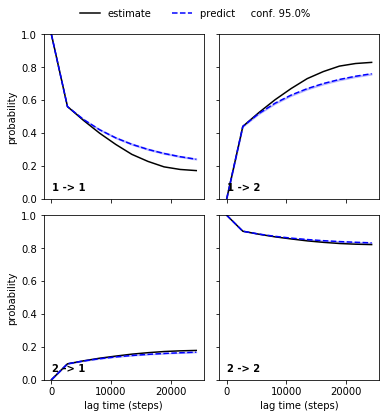

In [16]:
lag = get_lagtime_from_array(lags, 0.55, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(dtraj, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

The CK test fails and I recommend to discard this type of data as well.

## Discretization - how about heavy atom distances?

It is possible that residue minimum distances by themselfs are not sufficient, here. Let's try heavy atom distances and regspace clustering instead while keeping the TICA settings.

In [17]:
features = pyemma.coordinates.featurizer(pdb_file)
features.add_distances(features.select_Backbone())
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)

31-10-17 10:39:39 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[6] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


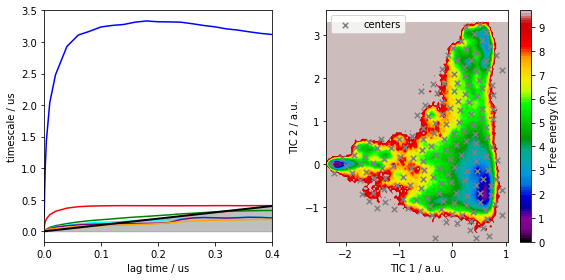

In [18]:
tica = pyemma.coordinates.tica(data=source, lag=5, dim=2).get_output()[0]
cluster = pyemma.coordinates.cluster_regspace(tica, max_centers=500, dmin=0.2)

lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(cluster.dtrajs, lags=lags, errors=None, nits=6),
    ylog=False, ax=axes[0], units='us', dt=2.0E-4)
pyemma.plots.plot_free_energy(*tica.T, ax=axes[1])
axes[1].scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
axes[1].legend()
axes[1].set_xlabel('TIC 1 / a.u.')
axes[1].set_ylabel('TIC 2 / a.u.')
fig.tight_layout()

We do observe a slightly better ITS convergence and higher ITS maximum than in the first attempt. We also resolve two faster processes. The CK test, however, fails for most combinations of more than two metastable states and lagtimes above $\tau=0.1\mu s$. The best result is shown below:

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Estimated at lagtime 500 steps


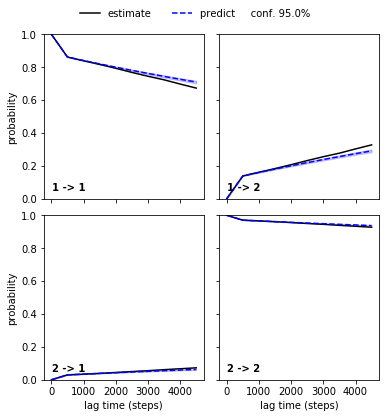

In [19]:
lag = get_lagtime_from_array(lags, 0.1, dt=2.0E-4)[1]
pyemma.plots.plot_cktest(pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us').cktest(2))
print('Estimated at lagtime %d steps' % lag)

For this parameter choice, we build an MSM and
- find two metastable states via PCCA,
- show the free energy surface in TICA space with the metastable state partitioning, and
- compute mean first passage times (MFPTs) between the metastable states.

/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


PI = [0.17432243344910814, 0.82567756655089208]
MFPT[0, 1] =  3 us
MFPT[1, 0] = 16 us


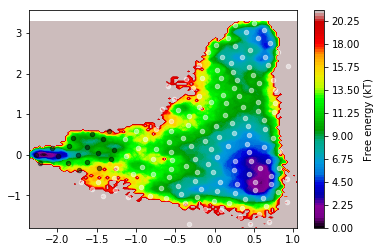

In [20]:
msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us')
msm.pcca(2)
fig, ax = pyemma.plots.plot_free_energy(*tica.T, weights=msm.pi[cluster.dtrajs])
ax.scatter(*cluster.clustercenters[msm.metastable_sets[0], :].T, s=20, c='black', alpha=0.5)
ax.scatter(*cluster.clustercenters[msm.metastable_sets[1], :].T, s=20, c='white', alpha=0.5)
print('PI = ' + str([msm.pi[s].sum() for s in msm.metastable_sets]))
print('MFPT[0, 1] = %2.0f us' % msm.mfpt(msm.metastable_sets[0], msm.metastable_sets[1]))
print('MFPT[1, 0] = %2.0f us' % msm.mfpt(msm.metastable_sets[1], msm.metastable_sets[0]))

## ToDo
- [ ] Are ``dim=2`` and ``lag=2`` good settings for TICA in this case?
- [ ] Do we need the RMSD feature? Test: Check correlation of the RMSD feature with all TICs.
- [ ] Do we need heavy atom distances or do the residue mindistances suffice with better TICA settings?

# PART 2: Post Analyses on the "final" Chris Model

I modified the Chris model just a little bit. Instead of using all the heavy atoms, I am using just the backbone, this way all testing process is a lot faster and the quality of the model is the same.

## Initial NM model

In [21]:
model0 = NonMarkovModel(cluster.dtrajs, msm.metastable_sets[0], msm.metastable_sets[1])

In [22]:
print("Macrostate populations: pA={:.2f}, pB={:.2f}".format(model0.popA, model0.popB))

Macrostate populations: pA=0.17, pB=0.83


### Empirical MFPTS
Notice that if we actually trace the discrete trajectory the MFPTs are far from the values reported in by  Lindorff-Larsen in the original paper. That is because the definition of macrostates is different from the paper.

#### Lag time = 1 step

In [23]:
MFPTs = model0.empirical_mfpts()
print('MFPT[0, 1] = {:2.0f} ns'.format(MFPTs['mfptAB']*0.2))
print('MFPT[1, 0] = {:2.0f} ns'.format(MFPTs['mfptBA']*0.2))

Number of A->B/B->A  events: 862/862
MFPT[0, 1] = 41 ns
MFPT[1, 0] = 200 ns


#### Lag time = 500 steps
If the lag time is long enough, MSM computes the properties of the **time-lagged ensemble** correctly.

In [24]:
model0.lag_time = 500
MFPTs = model0.empirical_mfpts()
print('MFPT[0, 1] = {:2.0f} us'.format(MFPTs['mfptAB']*0.0002))
print('MFPT[1, 0] = {:2.0f} us'.format(MFPTs['mfptBA']*0.0002))

Number of A->B/B->A  events: 12/12
MFPT[0, 1] =  3 us
MFPT[1, 0] = 14 us


### Non Markov MFPTs
The important message here is that the NM model reproduce the empirical MFPTs *at any lag time*. 

#### Lag time = 1 steps

In [25]:
model0.lag_time = 1
MFPTs = model0.mfpts()
print('MFPT[0, 1] = {:2.0f} ns'.format(MFPTs['mfptAB']*0.2))
print('MFPT[1, 0] = {:2.0f} ns'.format(MFPTs['mfptBA']*0.2))

MFPT[0, 1] = 42 ns
MFPT[1, 0] = 200 ns


#### Lag time = 500 steps

In [26]:
model0.lag_time = 500
MFPTs = model0.mfpts()
print('MFPT[0, 1] = {:2.0f} us'.format(MFPTs['mfptAB']*0.0002))
print('MFPT[1, 0] = {:2.0f} us'.format(MFPTs['mfptBA']*0.0002))

MFPT[0, 1] =  3 us
MFPT[1, 0] = 14 us


## New definition of macrostates from Agglomerative Clustering


In [27]:
msm1 = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=1, dt_traj='0.0002 us')

### Agglomerative Clustering from the transition matrix

Hierarchical agglomerative clustering using the Markovian commute time: $t_{ij} = \mathrm{MFPT}(i \rightarrow j)+ \mathrm{MFPT}(j \rightarrow i)$.

IMPORTANT: The goal of this clusterig is tho identify macrostates and not to use the best lag-time, the lag-time use for clustering could different from the one that would be appropiate for the final Markov model.

### Lag time = 1 step (just for clustering)

In [28]:
lag_to_use = [1]
lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]
range_per_lag = [[200,370]]

### Clustering

### Lag-time: 0.2ns

#### t_values:

t_cut: 40.00ns, t_min: 43.77ns, t_max: 4.19e+05ns, tAB: 8.61ns


/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


t_cut: 42.20ns, t_min: 43.77ns, t_max: 4.19e+05ns, tAB: 8.61ns
t_cut: 44.40ns, t_min: 45.50ns, t_max: 4.19e+05ns, tAB: 8.61ns
t_cut: 46.60ns, t_min: 50.50ns, t_max: 4.19e+05ns, tAB: 8.61ns
t_cut: 48.80ns, t_min: 50.50ns, t_max: 4.19e+05ns, tAB: 8.61ns
t_cut: 51.00ns, t_min: 57.23ns, t_max: 4.19e+05ns, tAB: 8.61ns
t_cut: 53.20ns, t_min: 57.23ns, t_max: 4.19e+05ns, tAB: 8.61ns
t_cut: 55.40ns, t_min: 57.23ns, t_max: 4.19e+05ns, tAB: 8.61ns
t_cut: 57.60ns, t_min: 66.94ns, t_max: 4.19e+05ns, tAB: 8.61ns
t_cut: 59.80ns, t_min: 66.94ns, t_max: 4.19e+05ns, tAB: 8.61ns
t_cut: 62.00ns, t_min: 66.94ns, t_max: 4.19e+05ns, tAB: 8.61ns
t_cut: 64.20ns, t_min: 66.94ns, t_max: 4.19e+05ns, tAB: 8.61ns
t_cut: 66.40ns, t_min: 66.94ns, t_max: 4.19e+05ns, tAB: 8.61ns
t_cut: 68.60ns, t_min: 70.68ns, t_max: 4.19e+05ns, tAB: 8.61ns
t_cut: 70.80ns, t_min: 72.28ns, t_max: 4.19e+05ns, tAB: 8.61ns


#### Observed clusters vs t_cut

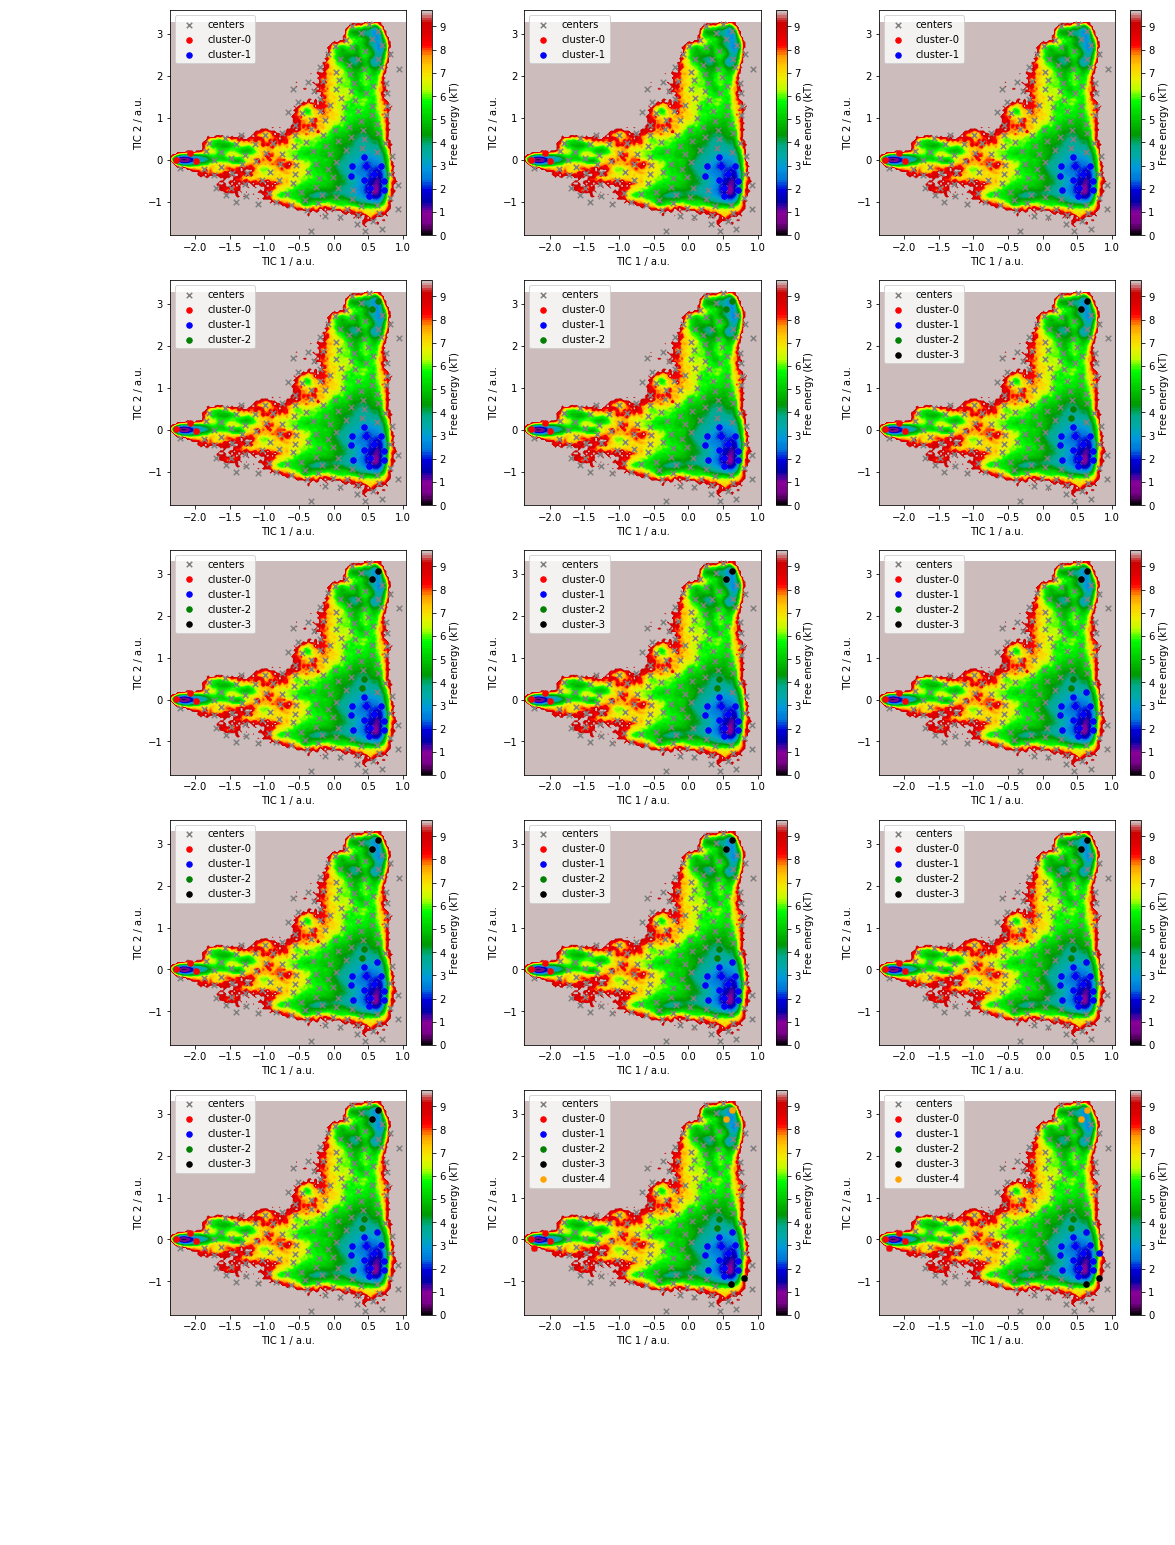

#### t_AB plots:

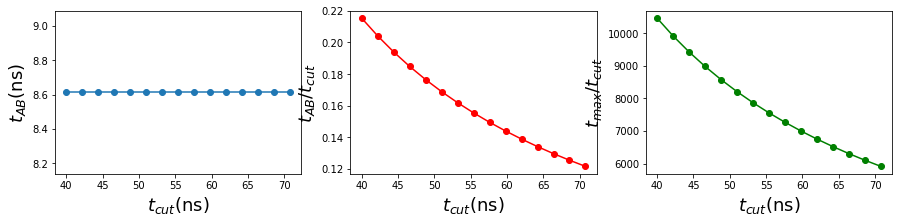

In [29]:
K = msm1.P
dt = 0.2
#---------------------
printmd("### Lag-time: "+str(dt)+"ns")

t_min_list=[]
t_max_list=[]
t_AB_list=[]

big_clusters_list = []

# t_cut range
min_ = range_per_lag[0][0]
max_ = range_per_lag[0][1]
interval = (max_ - min_)//15 
t_cut_values =  [min_+i for i in range(0,max_- min_,interval)][0:15]


fig_n_cols = 3
fig_n_rows = int(math.ceil(len(t_cut_values)/fig_n_cols))


fig = plt.figure(figsize=(6*fig_n_cols, 4.8*fig_n_rows))

printmd("#### t_values:")

for ii, t_cut in enumerate(t_cut_values):

    big_clusters=[]
    big_clusters_index =[]

    # clustering
    #clusters, t_min, t_max, clustered_tmatrix = kinetic_clustering_from_tmatrix(K, t_cut=t_cut, verbose=False)
    clusters, t_min, t_max = kinetic_clustering2_from_tmatrix(K, t_cut=t_cut, verbose=False)


    t_min_list.append(t_min)
    t_max_list.append(t_max)

    for i, cluster_i in enumerate(clusters):
        if len(cluster_i) > 1:
            big_clusters.append(cluster_i)
            big_clusters_index.append(i)

    n_big = len(big_clusters)

    macrostates = biggest_clusters_indexes(big_clusters, n_pick=2)
    #macrostates_list.append([ clusters[macrostates[i]] for i in range(len(macrostates))])
    big_clusters_list.append(big_clusters)

    if n_big > 1:
        #tAB = markov_commute_time(clustered_tmatrix,[macrostates[0]],[macrostates[1]] )
        tAB = markov_commute_time(K,[macrostates[0]],[macrostates[1]] )
    else:
        tAB = 0.0
    t_AB_list.append(tAB)

    print("t_cut: {:.2f}ns, t_min: {:.2f}ns, t_max: {:.2e}ns, tAB: {:.2f}ns".format(t_cut*dt, t_min*dt, t_max*dt, tAB*dt))

    plt.subplot(fig_n_rows, fig_n_cols, ii+1)
    pyemma.plots.plot_free_energy(*tica.T)
    plt.scatter(*cluster.clustercenters.T, marker='x', c='grey', s=30, label='centers')
    plt.annotate("t_cut: {:.2f}ns".format(t_cut*dt), xy=(-0.8,-4))

    colors = ['red','blue','green','black','orange'] + color_sequence

    for i, cluster_i in enumerate(big_clusters):
        cluster_i_tica_xy = []
        for index in cluster_i:
            cluster_i_tica_xy.append(cluster.clustercenters[index])
        cluster_i_tica_xy = np.array(cluster_i_tica_xy)
        plt.scatter(*cluster_i_tica_xy.T, marker='o', c=colors[i], s=30, label='cluster-'+str(i))

    plt.legend(loc='upper left')
    plt.xlabel('TIC 1 / a.u.')
    plt.ylabel('TIC 2 / a.u.')
        
printmd("#### Observed clusters vs t_cut")
plt.show()

printmd("#### t_AB plots:")
plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list)

In [30]:
# printmd("#### RMSD of the Macrostates:")
# plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs=cluster.dtrajs, step=100)

In [31]:
dt = 0.0002 # in micro-sec

stateA = big_clusters_list[6][1]  #Folded
stateB = big_clusters_list[6][0]   #Unfolded


#lag_to_use = np.asarray([1, 5, 10, 20, 50, 100, 500, 1000, 2000])


lag_to_use = np.asarray(list(lags[0::2]) + [5000, 10000, 15000, 20000, 30000])

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]

# MSM estimation
msm_models = [pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us') for lag in lag_to_use]

msm_mfptAB = np.asarray([msm_models[i].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm_models[i].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

In [32]:
model1 = NonMarkovModel(cluster.dtrajs, stateA, stateB)

In [33]:
model1.popA, model1.popB

(0.52228021600547936, 0.15476691508602095)

In [42]:
kinetics = model1.mfpts()
dt = 0.0002
print(kinetics['mfptAB']*dt,kinetics['mfptBA']*dt)

17.16478 3.71523740336


## Empirical and non-Markovian estimates

In [34]:
dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

std_errAB = []
std_errBA = []

for i, lag in enumerate(lag_to_use):
    
    nm_model = NonMarkovModel(cluster.dtrajs, stateA, stateB, lag_time=lag, sliding_window=True)
    
    nm_kinetics = nm_model.mfpts()
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 10/10
Number of A->B/B->A  events: 9/9
Number of A->B/B->A  events: 7/7
Number of A->B/B->A  events: 7/7
Number of A->B/B->A  events: 3/4


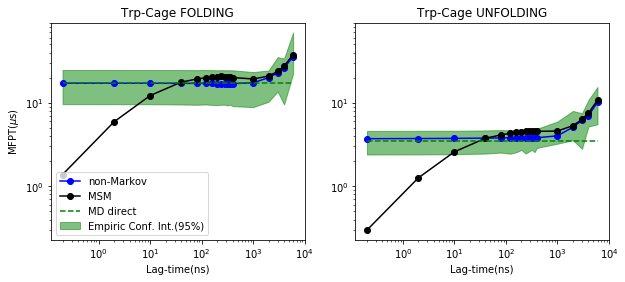

In [35]:
lag_to_use_ns = np.array(lag_to_use) * 0.2


empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)


fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empiric Conf. Int.(95%)" )
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="non-Markov", c='b')
ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct')
#ax1.plot(lag_to_use_ns, lag_to_use_ns/nm_model.popA/1000, c='purple')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Trp-Cage FOLDING")
ax1.set_xlabel("Lag-time(ns)")
ax1.set_ylabel("MFPT($\mu$s)")
plt.legend(loc='lower left')
#ax1.set_xlim(0,600)


ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green", label="Empiric Conf. Int.(95%)" )
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", label="non-Markov", c='b' )
ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k', label="MSM")
#ax2.plot(lag_to_use_ns, lag_to_use_ns/nm_model.popB/1000, color='purple')
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Trp-Cage UNFOLDING")
ax2.set_xlabel("Lag-time(ns)")
#ax2.set_xlim(0,600)

ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green', label='MD direct')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()

## Markov + Color : History Analysis (Lag=1tau)

In [36]:
dt =0.0002

discrete_traj = cluster.dtrajs

history = np.array([0, 50, 100, 300, 500, 1000, 2000, 3000])
mpc_mfptsAB = []
mpc_mfptsBA = []

for hist in history:
    model = MarkovPlusColorModel(discrete_traj, stateA, stateB, hist_length=hist)
    kinetics = model.mfpts()
    mpc_mfptsAB.append(kinetics['mfptAB']*dt)
    mpc_mfptsBA.append(kinetics['mfptBA']*dt)

# Empirical values:
emp_mfpts = model.empirical_mfpts()

emp_mfptAB = emp_mfpts['mfptAB']*dt
emp_mfptBA = emp_mfpts['mfptBA']*dt
emp_std_err_mfptAB = emp_mfpts['std_err_mfptAB']*dt
emp_std_err_mfptBA = emp_mfpts['std_err_mfptBA']*dt

Number of A->B/B->A  events: 10/10


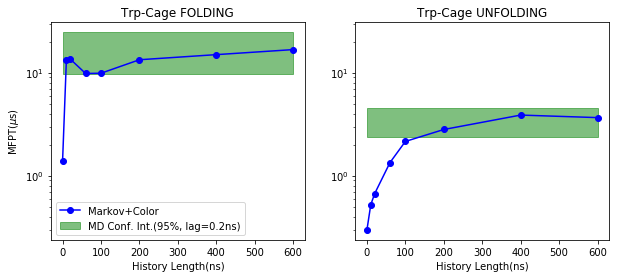

In [37]:
alpha = 0.5

fig =plt.figure(figsize = (10,4))

err_maxAB = [emp_mfptAB + 2*emp_std_err_mfptAB for _ in history]
err_minAB = [emp_mfptAB - 2*emp_std_err_mfptAB for _ in history]
err_maxBA = [emp_mfptBA + 2*emp_std_err_mfptBA for _ in history]
err_minBA = [emp_mfptBA - 2*emp_std_err_mfptBA for _ in history]

ax1 = fig.add_subplot(121)
ax1.fill_between(history*0.2, err_minAB, err_maxAB,
                 alpha=alpha, color="green", label="MD Conf. Int.(95%, lag=0.2ns)" )
ax1.plot(history*0.2, mpc_mfptsAB, "-o", label="Markov+Color", color='b')
ax1.set_yscale("log")
ax1.set_title("Trp-Cage FOLDING")
ax1.set_xlabel("History Length(ns)")
ax1.set_ylabel("MFPT($\mu$s)")
ax1.legend(loc='lower left')
#ax1.set_xlim(-2,80)
#ax1.set_ylim(0.01,10)

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(history*0.2, err_minBA, err_maxBA,
                 alpha=alpha, color="green", label="Conf. Int.(95%)" )
ax2.plot(history*0.2, mpc_mfptsBA, "-o", label="Markov+Color", color='b')
ax2.set_yscale("log")
ax2.set_title("Trp-Cage UNFOLDING")
ax2.set_xlabel("History Length(ns)")
#ax2.legend(loc='upper left')
#ax2.set_xlim(-2,80)
#ax2.set_ylim(0.01,10)

plt.show()

### t_b

In [38]:
nm_model.lag_time = 1
empiric_fptsAB, empiric_fptsBA, tb_values = nm_model.empirical_fpts()

###  Average $t_b$ = 383.28ns

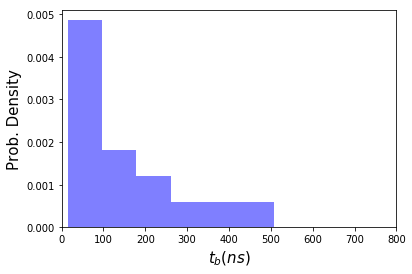

In [39]:
printmd("###  Average $t_b$ = {:.2f}ns".format(0.2*sum(tb_values)/len(tb_values)))

plt.hist(np.array(tb_values)*0.2, normed=True, bins=20, color='blue', alpha=0.5)
plt.xlabel("$t_b (ns)$", fontsize=15)
plt.ylabel("Prob. Density", fontsize=15)
plt.annotate
plt.xlim([0,800])
plt.show()

## Correlation functions

In [40]:
times =  range(400, 20000, 400)
times_in_us = np.array(times)*0.0002

emp_coorAB = nm_model.empirical_corr_function(nm_model.stateA, nm_model.stateB, times=times)
emp_coorAA = nm_model.empirical_corr_function(nm_model.stateA, nm_model.stateA, times=times)
emp_coorBB = nm_model.empirical_corr_function(nm_model.stateB, nm_model.stateB, times=times)

                                              LAG TIME: 0.2ns


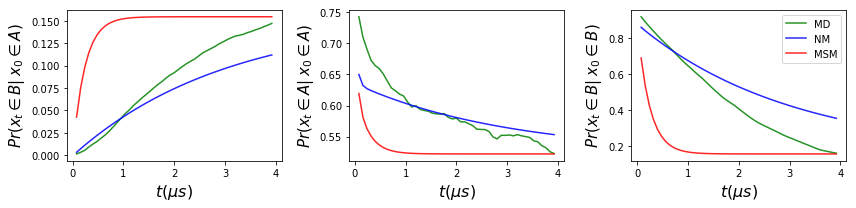

                                              LAG TIME: 2.0ns


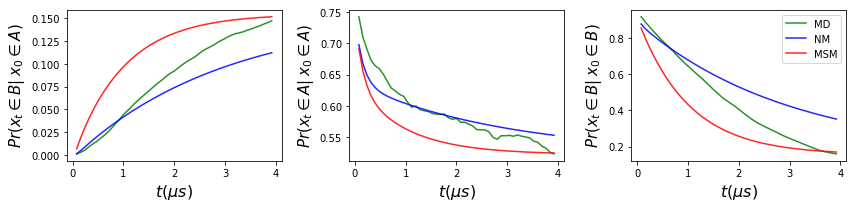

                                              LAG TIME: 10.0ns


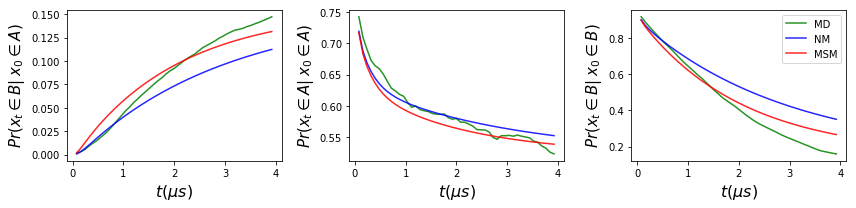

                                              LAG TIME: 20.0ns


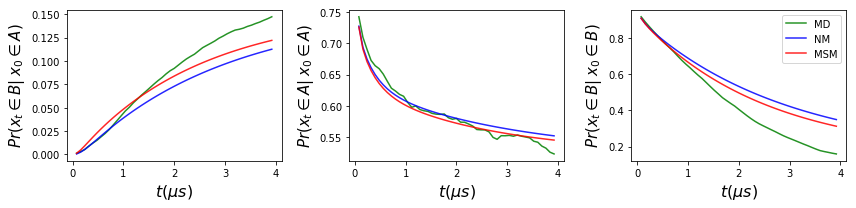

                                              LAG TIME: 40.0ns


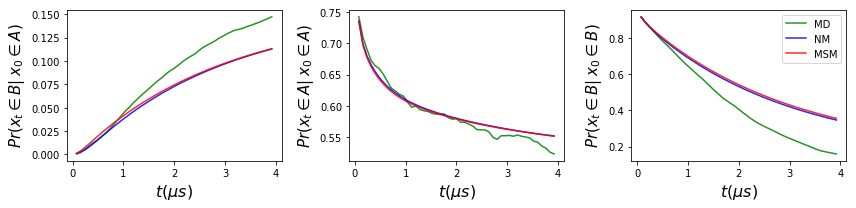

                                              LAG TIME: 80.0ns


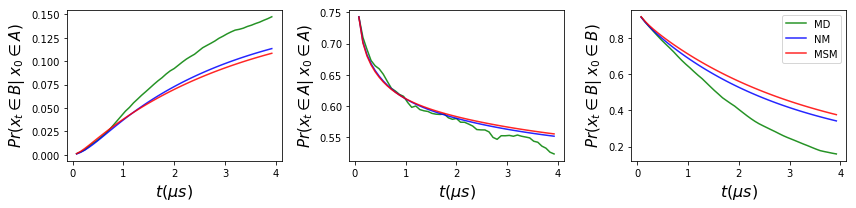

In [41]:
pA = nm_model.popA
pB = nm_model.popB

alpha = 0.85

for lag in [1, 10, 50, 100, 200, 400]:

    nm_model.lag_time=lag
    print(46*' ' + 'LAG TIME: {}ns'.format(lag*0.2))

    nm_pAA, nm_pAB, nm_pBA, nm_pBB = nm_model.corr_function(times=times)
    
    nm_model.markovian = True
    msm_pAA, msm_pAB, msm_pBA, msm_pBB = nm_model.corr_function(times=times)
    nm_model.markovian = False

    fig = plt.figure(figsize=(12,3))
    fig.add_subplot(131)
    plt.plot(times_in_us, emp_coorAB/pA, label='MD', color='green', alpha=alpha)
    plt.plot(times_in_us, nm_pAB/pA, label='NM', color='blue', alpha=alpha)
    plt.plot(times_in_us, msm_pAB/pA, label='MSM', color='red', alpha=alpha)
    plt.xlabel('$t(\mu s)$', fontsize=16)
    plt.ylabel('$Pr(x_t \in B|\; x_0 \in A)$', fontsize=15)
    #plt.ylim([0,0.2])

    fig.add_subplot(132)
    plt.plot(times_in_us, emp_coorAA/pA, label='MD', color='green', alpha=alpha)
    plt.plot(times_in_us, nm_pAA/pA, label='NM', color='blue', alpha=alpha)
    plt.plot(times_in_us, msm_pAA/pA, label='MSM', color='red', alpha=alpha)
    plt.xlabel('$t(\mu s)$', fontsize=16)
    plt.ylabel('$Pr(x_t \in A|\; x_0 \in A)$', fontsize=15)
    #plt.ylim([0.5,1])
    
    fig.add_subplot(133)
    plt.plot(times_in_us, emp_coorBB/pB, label='MD', color='green', alpha=alpha)
    plt.plot(times_in_us, nm_pBB/pB, label='NM', color='blue', alpha=alpha)
    plt.plot(times_in_us, msm_pBB/pB, label='MSM', color='red', alpha=alpha )
    plt.xlabel('$t(\mu s)$', fontsize=16)
    plt.ylabel('$Pr(x_t \in B|\; x_0 \in B)$', fontsize=15)
    plt.legend(loc='upper right')
    #plt.ylim([0.5,1])

    fig.tight_layout()

    plt.show()